In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
from scipy.signal import convolve
import scipy
from joblib import Parallel, delayed
import time
from scipy import sparse
from tqdm import tqdm, tqdm_notebook

%run ../Scripts/immunity.py
%run ../Scripts/altimmunity.py
%run ../Scripts/initMethods.py
%run ../Scripts/randomHGT.py
%run ../Scripts/coverage.py
%run ../Scripts/fitness.py
%run ../Scripts/supMethods.py
%run ../Scripts/mutation.py

In [2]:
params = { #parameters relevant for the equations
    "Nh":                  10000,
    "N0":                   1000, #This Will be updated by self-consitent solution
    "R0":                    100, 
    "M0":                      5, #Also L, total number of spacers
    "mu":                   0.01, #mutation rate
    "gamma_shape":            20, 
    "Np":                     10, #Number of Cas Protein
    "dc":                      3, #Required number of complexes to activate defence
    "h":                       4, #coordination coeff
    "r":                    2000, #cross-reactivity kernel
    "beta":                 0.000,
    "rate_HGT":              1/20,
    "HGT_bonus_acquisition": 5000,
    "rate_recovery":          0.1,
}
sim_params = { #parameters relevant for the simulation (including Inital Valuess)
    "continue":                 False, #DO NOT CREATE ARBITRARY FOLDERS ONLY FOR TESTS
    "xdomain":                    500,
    "dx":                           1,
    "tf":                         100,
    "dt":                           1,
    "initial_mean_n":           [0,0],
    "initial_mean_nh":          [0,0],
    "conv_size":                  500,
    "num_threads":                  4,
    "t_snapshot":                  10,
    "initial_mean_n":         [0,-100],
    "initial_var_n":               40,
    "initial_mean_nh":         [0,150],
    "initial_var_nh":              40,
    "seed":                         32,
}

In [3]:
n = init_guassian(params["N0"], sim_params, "n")
nh = init_guassian(params["Nh"]*params["M0"], sim_params, "nh")
params["M"] = params["M0"]
kernel_quarter = init_quarter_kernel(params, sim_params)
kernel_exp = init_quarter_kernel(params, sim_params, type="Boltzmann")

In [4]:
t = 0
sim_params["time_next_event"] = get_time_next_HGT(t, params, sim_params)
N_data = []
Nh_data = []
to_add_data = []
time = []

while(t < sim_params["tf"]):
    p = elementwise_coverage(nh, n, kernel_quarter, params, sim_params)

    f = fitness_spacers(n, nh, p, params, sim_params) #f is now a masked array (where mask is where eff_R0 = 0)
    f = norm_fitness(f, n, params, sim_params) #renormalize f
    n = virus_growth(n, f, params, sim_params) #update
    n = mutation(n, params, sim_params)
    
    params, sim_params, num_to_add, num_to_remove = HGT_logistic_event(t, n, params, sim_params, toprint = True)

    nh_gain = immunity_gain_from_kernel(nh, n, kernel_exp, params, sim_params, num_to_add) #update nh
    nh = immunity_loss_uniform(nh_gain, n, params, sim_params, num_to_remove)

    time.append(t)
    Nh_data.append(np.sum(nh))
    N_data.append(np.sum(n))
    to_add_data.append(num_to_add)

    t += sim_params["dt"]

Nothing happens at time: 0
Nothing happens at time: 1
Nothing happens at time: 2
Nothing happens at time: 3
Nothing happens at time: 4
HGT Occurs at time: 5
Lower Acquisition: 6
Lower Acquisition: 7
HGT Occurs at time: 8
Lower Acquisition: 9
Lower Acquisition: 10
Lower Acquisition: 11
Lower Acquisition: 12
Lower Acquisition: 13
Lower Acquisition: 14
Lower Acquisition: 15
Lower Acquisition: 16
Lower Acquisition: 17
Lower Acquisition: 18
Lower Acquisition: 19
Lower Acquisition: 20
Lower Acquisition: 21
Lower Acquisition: 22
Lower Acquisition: 23
HGT Occurs at time: 24
Lower Acquisition: 25
Lower Acquisition: 26
Lower Acquisition: 27
Lower Acquisition: 28
Lower Acquisition: 29
Lower Acquisition: 30
Lower Acquisition: 31
Lower Acquisition: 32
Lower Acquisition: 33
Lower Acquisition: 34
Lower Acquisition: 35
Lower Acquisition: 36
Lower Acquisition: 37
HGT Occurs at time: 38
Lower Acquisition: 39
Lower Acquisition: 40
Lower Acquisition: 41
Lower Acquisition: 42
HGT Occurs at time: 43
Lower A

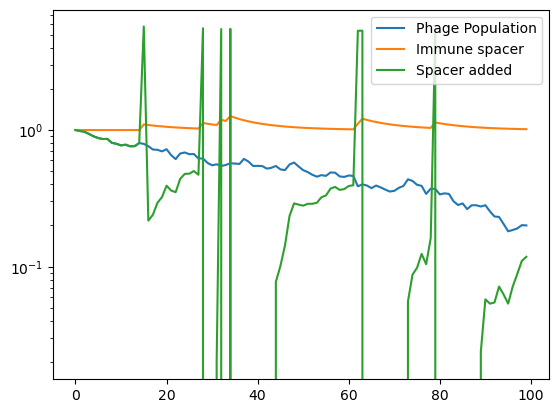

In [77]:
plt.plot(time, N_data/N_data[0], label = "Phage Population")
plt.plot(time, Nh_data/Nh_data[0], label = "Immune spacer")
plt.plot(time, to_add_data/to_add_data[0], label = "Spacer added")
plt.yscale("log")
plt.legend()


In [58]:
n = init_guassian(params["N0"], sim_params, "n")
nh = init_guassian(params["Nh"]*params["M0"], sim_params, "nh")
params["M"] = params["M0"]
kernel_quarter = init_quarter_kernel(params, sim_params)
kernel_exp = init_quarter_kernel(params, sim_params, type="Boltzmann")

In [ ]:
t = 0
time2nextevent = get_time_next_HGT(t, params, sim_params)
time2nextevent = 4
rate_recovery = 0.1
N_data = []
Nh_data = []
to_add_data = []
time = []

while(t < sim_params["tf"]):
    

    if t > time2nextevent:
        print("HGT Occurs at time:", t)

        num_to_add = np.sum(n) + params["HGT_bonus_acquisition"]
        num_to_remove = np.sum(n)
        params["M"] = params["M"] + params["HGT_bonus_acquisition"]/params["Nh"]

        time2nextevent = get_time_next_HGT(t, params, sim_params)

    elif params["M"] > params["M0"]:
        print("Lower Acquisition:", t)
        tt_spacers_current = int(params["M"]*params["Nh"])
        tt_spacers_lost = np.rint(params["Nh"]*(1-(params["M"]/params["M0"]))*params["M"]*rate_recovery)
        params["M"] = params["M"] + tt_spacers_lost/int(params["Nh"])

        num_to_add = np.sum(n) + tt_spacers_lost
        if num_to_add < 0:
            num_to_add = 0
        num_to_remove = tt_spacers_current - int(params["Nh"]*params["M"]) + num_to_add

    else:
        print("Nothing happens at time:", t)

        num_to_add = np.sum(n)
        num_to_remove = np.sum(n)

    print(params["M"])
    nh_gain = immunity_gain_from_kernel(nh, n, kernel_exp, params, sim_params, num_to_add) #update nh
    nh = immunity_loss_uniform(nh_gain, n, params, sim_params, num_to_remove)

    time.append(t)
    Nh_data.append(np.sum(nh))
    N_data.append(np.sum(n))
    to_add_data.append(num_to_add)

    t += sim_params["dt"]

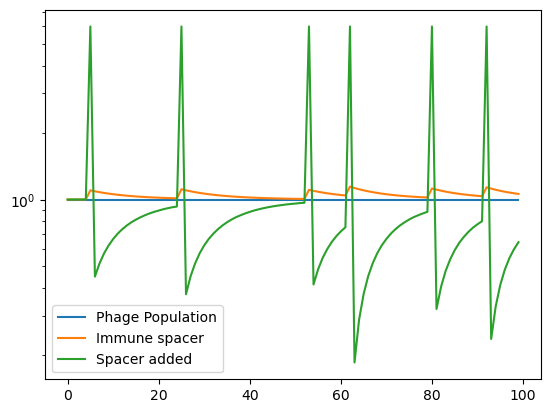

In [64]:
plt.plot(time, N_data/N_data[0], label = "Phage Population")
plt.plot(time, Nh_data/Nh_data[0], label = "Immune spacer")
plt.plot(time, to_add_data/to_add_data[0], label = "Spacer added")
plt.yscale("log")
plt.legend()
